<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Statistic/Python_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://reneshbedre.github.io/blog/anova.html

# One-way (one factor) ANOVA with Python

ANOVA Hypotheses

- Null hypotheses: Groups means are equal (no variation in means of groups)
- Alternative hypotheses: At least, one group mean is different from other groups

ANOVA Assumptions

- Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
- Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
- Observations are sampled independently from each other

How ANOVA works?

- Check sample sizes: equal number of observation in each group
- Calculate Mean Square for each group (MS) (SS of group/level-1); level-1 is a degree of freedom (df) for a group
- Calculate Mean Square error (MSE) (SS error/df of residuals)
- Calculate F-value (MS of group/MSE)

In [37]:
# I am using Python 3
# load packages
import pandas as pd
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
d

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


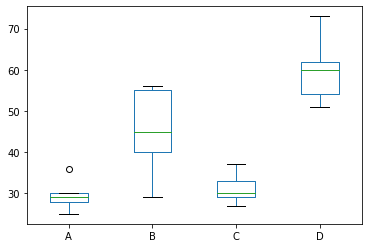

In [38]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
d.boxplot(column=['A', 'B', 'C', 'D'], grid=False)

In [39]:
# load packages
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d['A'], d['B'], d['C'], d['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


In [40]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
d_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


In [41]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


In [16]:
# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

Interpretation: The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among treatments.

From ANOVA analysis, we know that treatment differences are statistically significant, but ANOVA does not tell which treatments are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

## Test ANOVA assumptions

ANOVA Assumptions

- Residuals (experimental error) are normally distributed (Shapiro-Wilks Test)
- Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
- Observations are sampled independently from each other

The Shapiro-Wilk test can be used to check the normal distribution of residuals . Null hypothesis: data is drawn from normal distribution.

In [28]:
model.resid

0    -4.600000e+00
1     4.000000e-01
2    -1.600000e+00
3     6.400000e+00
4    -6.000000e-01
5     0.000000e+00
6     1.000000e+01
7    -1.600000e+01
8     1.100000e+01
9    -5.000000e+00
10   -1.200000e+00
11   -2.200000e+00
12    1.800000e+00
13    5.800000e+00
14   -4.200000e+00
15   -6.000000e+00
16    7.105427e-15
17   -9.000000e+00
18    2.000000e+00
19    1.300000e+01
dtype: float64

In [25]:
# load packages
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


As the P-value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.

As the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.

In [26]:
# load packages
import scipy.stats as stats
w, pvalue = stats.bartlett(d['A'], d['B'], d['C'], d['D'])
print(w, pvalue)

5.687843565012841 0.1278253399753447


As the P-value (0.12) is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

Levene test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [27]:
from scipy.stats import levene
stat, pvalue = levene(d['A'], d['B'], d['C'], d['D'])
print(stat, pvalue)

1.9219593192195938 0.16673281219949276


## Tukey HSD test

In [ ]:
#!pip install pingouin

In [17]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='treatments').round(3)
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.6,45.0,-15.4,4.790616,-3.214618,0.010718,-1.836351
1,A,C,29.6,31.2,-1.6,4.790616,-0.333986,0.900000,-0.190790
2,A,D,29.6,60.0,-30.4,4.790616,-6.345739,0.001000,-3.625005
3,B,C,45.0,31.2,13.8,4.790616,2.880632,0.027410,1.645561
4,B,D,45.0,60.0,-15.0,4.790616,-3.131121,0.013679,-1.788654
5,C,D,31.2,60.0,-28.8,4.790616,-6.011753,0.001000,-3.434215


In [23]:
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')

In [24]:
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,A,B,29.6,45.0,-15.4,4.790616,-3.214618,0.010718,-1.836351,Different
1,A,C,29.6,31.2,-1.6,4.790616,-0.333986,0.900000,-0.190790,Not different
2,A,D,29.6,60.0,-30.4,4.790616,-6.345739,0.001000,-3.625005,Different
3,B,C,45.0,31.2,13.8,4.790616,2.880632,0.027410,1.645561,Different
4,B,D,45.0,60.0,-15.0,4.790616,-3.131121,0.013679,-1.788654,Different
5,C,D,31.2,60.0,-28.8,4.790616,-6.011753,0.001000,-3.434215,Different


Above results from Tukey HSD suggests that except A-C, all other pairwise comparisons for treatments rejects null hypothesis (P-tukey<0.05) and indicates statistical significant differences.

# Two-way (two factor) ANOVA with Python

From dataset, there are two factors (independent variables) viz. genotypes and yield in years. Genotypes and years has five and three levels respectively (see one-way ANOVA to know factors and levels).

For this experimental design, there are two factors to evaluate, and therefore, two-way ANOVA method is suitable for analysis. Here, using two-way ANOVA, we can simultaneously evaluate how type of genotype and years affects the yields of plants. If you apply one-way ANOVA here, you can able to evaluate only one factor at a time.

From two-way ANOVA, we can tests three hypotheses 1) effect of genotype on yield 2) effect of time (years) on yield, and 3) effect of genotype and time (years) interactions on yield

In [44]:
# load packages
import pandas as pd
import seaborn as sns
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
d

,Genotype,1_year,2_year,3_year
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


In [45]:
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head(10)

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94
5,B,1_year,4.02
6,C,1_year,3.99
7,C,1_year,3.30
8,C,1_year,4.41
9,D,1_year,3.75


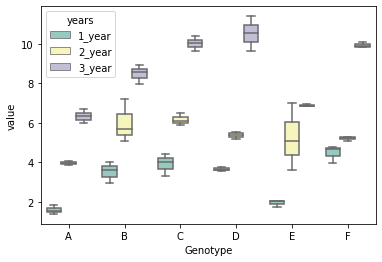

In [46]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt, palette="Set3") 

In [35]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2) #typ = 3 for unblanced
anova_table

,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


Interpretation: The P-value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant (P<0.05). We conclude that type of genotype significantly affects the yield outcome, time (years) significantly affects the yield outcome, and interaction of both genotype and time (years) significantly affects the yield outcome.

Note: If you have unbalanced (unequal sample size for each group) data, you can perform similar steps as described for two-way ANOVA with the balanced design but set `typ=3`. Type 3 sums of squares (SS) is recommended for an unbalanced design for multifactorial ANOVA.

## Test ANOVA assumptions

Similar to one-way ANOVA, you can use Levene and Shapiro-Wilk test to validate the assumptions for homogeneity of variances and normal distribution of residuals.

## Tukey HSD test.

Now, we know that genotype and time (years) differences are statistically significant, but ANOVA does not tell which genotype and time (years) are significantly different from each other. To know the pairs of significant different genotype and time (years), perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.



In [48]:
d_melt.head()

,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


In [54]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='Genotype').round(3)
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,A,B,3.957,5.997,-2.040,1.196,-1.706,0.523,-0.766,Not different
1,A,C,3.957,6.690,-2.733,1.196,-2.286,0.207,-1.026,Not different
2,A,D,3.957,6.517,-2.560,1.196,-2.141,0.273,-0.961,Not different
3,A,E,3.957,4.677,-0.720,1.196,-0.602,0.900,-0.270,Not different
4,A,F,3.957,6.530,-2.573,1.196,-2.152,0.267,-0.966,Not different
5,B,C,5.997,6.690,-0.693,1.196,-0.580,0.900,-0.260,Not different
6,B,D,5.997,6.517,-0.520,1.196,-0.435,0.900,-0.195,Not different
7,B,E,5.997,4.677,1.320,1.196,1.104,0.864,0.496,Not different
8,B,F,5.997,6.530,-0.533,1.196,-0.446,0.900,-0.200,Not different
9,C,D,6.690,6.517,0.173,1.196,0.145,0.900,0.065,Not different


In [55]:
m_comp = pairwise_tukey(data=d_melt, dv='value', between='years').round(3)
m_comp['Result']=m_comp['p-tukey'].apply(lambda x: 'Different'if x<0.05 else 'Not different')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Result
0,1_year,2_year,3.172,5.318,-2.147,0.439,-4.887,0.001,-1.593,Different
1,1_year,3_year,3.172,8.693,-5.522,0.439,-12.572,0.001,-4.097,Different
2,2_year,3_year,5.318,8.693,-3.375,0.439,-7.684,0.001,-2.504,Different
